In [1]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Bidirectional
from keras.layers import GRU
import  pandas as pd
import numpy as np
import tensorflow as tf
import re
import keras as kr
from keras.models import Model
from collections import Counter
from tensorflow.contrib import learn
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
import nltk

Using TensorFlow backend.


In [2]:
dir_1 = r'all_data_new_1.csv'

df = pd.read_csv(dir_1)
print(df.shape)
df.head()

(16251, 3)


,text,title,type
0,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",1
1,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,1
2,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",1
3,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,1
4,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,1


In [3]:
df['type'] = df['type'].astype(int)
print(df['type'][:5])

0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64


In [4]:
sum(df['type'].values)

4903

文本预处理

In [5]:
def cleanlines(line,remove_stopwords=False):   
    p1=re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
    p2=re.compile(r'[(][: @ . , ？！\s][)]')
    p3=re.compile(r'[「『]')
    p4=re.compile(r'[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）0-9 , : ; \-\ \[\ \]\ ]')
    p5=re.compile(r'[^a-zA-Z]')
    line=p1.sub(r' ',line)
    line=p2.sub(r' ',line)
    line=p3.sub(r' ',line)
    line=p4.sub(r' ',line)
    line=p5.sub(r' ',line)
    words = line.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in eng_stopwords]
    return words

In [6]:
eng_stopwords = [line.rstrip() for line in open('stop_words.txt')]
eng_stopwords[:5]

["'d", "'ll", "'m", "'re", "'s"]

In [7]:
df['text'] = df['text'].astype(str)
sents = df['text']
text_words=[cleanlines(sent,remove_stopwords=True) for sent in sents]

In [8]:
len(text_words)

16251

In [9]:
df['title'] = df['title'].astype(str)
title_sents = df['title']
title_words=[cleanlines(sent,remove_stopwords=True) for sent in title_sents]

In [10]:
def concat_text(text_words,title_words):
    concat_text = []
    for i in range(len(text_words)):
        temp = text_words[i]+title_words[i]
        concat_text.append(temp)
    return concat_text

concat_text = concat_text(text_words,title_words)

In [11]:
len(concat_text)

16251

建立词典

In [12]:
# set parameters:
vocab_size= 5000 
batch_size = 200 
sequence_length = 300 
embedding_dims=128 

In [13]:
def build_vocab(content_list,vocab_size):
    vocab_size = vocab_size
    all_vocabs = []
    for content in content_list:
        all_vocabs.extend(list(content))
    #计数，得到元素与对应的个数对(元素,个数)
    counter = Counter(all_vocabs)
    #取字典大小的元素形成字典
    count_pairs = counter.most_common(vocab_size - 1) 
    words, _ = list(zip(*count_pairs))
    words = ['<PAD>'] + list(words)
    open('vocab.txt', mode='w', encoding='utf-8', errors='ignore').write('\n'.join(words) + '\n')
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [14]:
words, word_to_id = build_vocab(concat_text,vocab_size)

In [15]:
def get_pad_text(text_words, word_to_id, max_length=100):
    data_id=[]
    for x in text_words:
        single_text=[]
        for i in x:
            if i in words:
                a=word_to_id[i]
                single_text.append(a)
        data_id.append(single_text)
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    return np.array(x_pad)

X = get_pad_text(concat_text,word_to_id,max_length=sequence_length)

In [68]:
X.shape

(16251, 300)

In [69]:
def train_dev_split(X,y):
    
    np.random.seed(10)
    shuffle_indices = np.random.permutation(len(y))
    x_shuffled = X[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    # Split train/test set
    dev_sample_index = -1 * int(0.1 * float(len(y)))
    x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
    print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
    return x_train, y_train, word_to_id, x_dev, y_dev

In [70]:
y = np.array(df['type'])
x_train, y_train, word_to_id, x_dev, y_dev = train_dev_split(X,y)

Train/Dev split: 14626/1625


In [71]:
sum(y_dev)

471

RNN model:LSTM

In [72]:
# create and fit the LSTM network
model = Sequential()
model.add(Embedding(vocab_size, embedding_dims, input_length=sequence_length))
model.add(LSTM(512,dropout=0.2,recurrent_dropout=0.2))
model.add(Dropout(0.2))
#model.add(LSTM(512, return_sequences=True))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


In [73]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [74]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_acc',patience=5)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [es,checkpoint]

In [ ]:
model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,
          callbacks=[es],
          epochs=5,
          shuffle=True)

Train on 13163 samples, validate on 1463 samples
Epoch 1/5
13163/13163 [==============================] - 813s 62ms/step - loss: 0.2686 - acc: 0.9259 - val_loss: 0.0340 - val_acc: 0.9911
Epoch 2/5
 7800/13163 [================>.............] - ETA: 51:51 - loss: 0.0176 - acc: 0.9954

BiRNN

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dims, input_length=sequence_length))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2))
model.add(Dropout(0.2))
#model.add(LSTM(512, return_sequences=True))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [51]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_acc',patience=5)

filepath="bilstm_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [es,checkpoint]

In [ ]:

model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,
          callbacks=[es],
          epochs=8,
          shuffle=True)

Train on 13163 samples, validate on 1463 samples
Epoch 1/8


In [49]:
pred_y = model.predict(x_dev)

KeyboardInterrupt: 

In [28]:
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(pred_y)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [30]:
# Compute confusion matrix
con_matrix = confusion_matrix(results, y_dev,labels=[0,1])  # 生成混淆矩阵
print(con_matrix)

[[1153    8]
 [   1  463]]


In [23]:
print('precsion:',precision_score(y_dev, results))
print('recall:',recall_score(y_dev, results))
print('f1:',f1_score(y_dev, results))

NameError: name 'precision_score' is not defined

In [35]:
y_scores = pd.DataFrame(pred_y)[0].values
print(y_scores[:2])

[9.999950e-01 1.326043e-05]


In [36]:
print(classification_report(y_dev, results))
auc_value = roc_auc_score(y_dev, y_scores)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1154
          1       1.00      0.98      0.99       471

avg / total       0.99      0.99      0.99      1625



In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

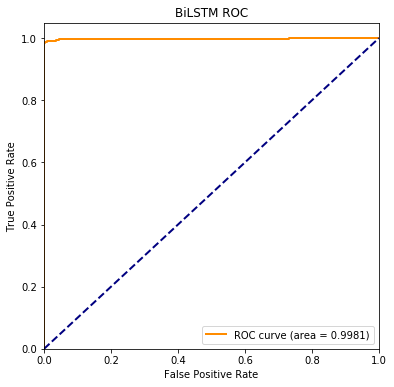

In [39]:
fpr, tpr, thresholds = roc_curve(y_dev, y_scores, pos_label=1.0)
plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BiLSTM ROC')
plt.legend(loc="lower right")

**测试新闻**

In [43]:
text_new = ' WASHINGTON — An American citizen who was abducted nearly 18 months ago in the Yemeni city of Sana was freed last week and has been reunited with his family, President Trump announced on Monday.Danny Lavone Burch, an engineer at a Yemeni oil company, has been “recovered and reunited with his wife and children,” Mr. Trump tweeted aboard Air Force One as he flew toward Vietnam, where he is to meet this week with Kim Jong-un, the North Korean leader.I appreciate the support of the United Arab Emirates in bringing Danny home,” the president wrote. “Danny’s recovery reflects the best of what the United States & its partners can accomplish.”Mr. Trump did not specify how Mr. Burch, who is married to a Yemeni woman, was freed. It also was not clear who had abducted Mr. Burch, although former American officials said he was not being held by Al Qaeda.Mr. Burch is an engineer at a Yemeni oil company and is married to a Yemeni woman.Nadia ForsaMr. Burch is an engineer at a Yemeni oil company and is married to a Yemeni woman.Nadia ForsaWorking closely with American forces, the United Arab Emirates has stationed ground troops in Yemen to fight Houthi rebels in the country’s ongoing civil war. American officials have previously told The New York Times that freeing Mr. Burch likely would have required a raid; a State Department spokesman on Monday said the United Arab Emirates was “crucial” to securing his release.Two American officials discussed the details of the case on Monday on condition of anonymity.Mr. Burch, who had been working for oil companies in Yemen for years, was 63 when he was forced from his car by unidentified gunmen in September 2017. At the time, Nadia Forsa, Mr. Burch’s wife, said in a phone interview that “they did it in broad daylight in front of everyone.”Kidnappings of Americans and other Westerners are common in Yemen, a poor country that has been devastated by years of civil unrest. Houthi rebels and affiliates of Al Qaeda often attempt to ransom hostages for money or accuse them of being spies.At the time of Mr. Burch’s abduction, no group claimed responsibility.Mr. Burch began working on oil rigs in Yemen in the mid-1990s. He traveled between the United States and Yemen before moving there permanently, according to Stephen Burch, his son from his first marriage, in an interview shortly after he was taken in 2017.Stephen Burch said then that his father had divorced his first wife and had virtually no contact with him or his other children from the first marriage.In his tweets on Monday, Mr. Trump said recovering American hostages “is a priority of my Admin, and with Danny’s release, we have now secured freedom for 20 American captives since my election victory.”" '

In [44]:
text_words_new=[cleanlines(text_new,remove_stopwords=True)]


In [45]:
print(text_words_new[0])

['washington', 'american', 'citizen', 'abducted', 'months', 'ago', 'yemeni', 'city', 'sana', 'freed', 'week', 'reunited', 'family', 'president', 'trump', 'announced', 'monday', 'danny', 'lavone', 'burch', 'engineer', 'yemeni', 'oil', 'company', 'recovered', 'reunited', 'wife', 'children', 'trump', 'tweeted', 'aboard', 'air', 'force', 'flew', 'vietnam', 'meet', 'week', 'kim', 'jong', 'north', 'korean', 'leader', 'support', 'united', 'arab', 'emirates', 'bringing', 'danny', 'president', 'wrote', 'danny', 'recovery', 'reflects', 'united', 'partners', 'accomplish', 'trump', 'burch', 'married', 'yemeni', 'woman', 'freed', 'abducted', 'burch', 'american', 'officials', 'held', 'al', 'qaeda', 'burch', 'engineer', 'yemeni', 'oil', 'company', 'married', 'yemeni', 'woman', 'nadia', 'forsamr', 'burch', 'engineer', 'yemeni', 'oil', 'company', 'married', 'yemeni', 'woman', 'nadia', 'forsaworking', 'closely', 'american', 'forces', 'united', 'arab', 'emirates', 'stationed', 'ground', 'troops', 'yemen'

In [46]:
X_new = get_pad_text(text_words_new,word_to_id,max_length=sequence_length)
print(X_new.shape)

(1, 300)


In [47]:
X_new

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [48]:
model.predict(X_new)

array([[0.50044227]], dtype=float32)